# Phân loại bình luận tích cực và tiêu cực trên các quán ăn

In [1]:
import pandas as pd
import string
import numpy as np
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
import plotly.graph_objects as go
import re
import warnings as wrn
wrn.filterwarnings('ignore')

In [2]:
df = pd.read_csv('small_data.csv')
df['Label'] = df['Point'].apply(lambda point: 0 if point >= 6  else 1)
sentences = df['Review'].tolist()
joined_sentences = " ".join(sentences)

## Khai phá dữ liệu

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  1030 non-null   object 
 1   Point   1030 non-null   float64
 2   Label   1030 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 24.3+ KB


In [4]:
df.describe()

,Point,Label
count,1030.000000,1030.000000
mean,6.047184,0.407767
std,2.631097,0.491658
min,1.000000,0.000000
25%,4.000000,0.000000
50%,7.000000,0.000000
75%,8.000000,1.000000
max,10.000000,1.000000


<i>Dữ liệu trước khi tiền xử lý</i>

In [5]:
df

,Review,Point,Label
0,"Quán không gian không có địa điểm ăn tại chỗ, ...",4.4,1
1,mình có ord ở đây 2combo bánh mì tiêu đen + co...,2.0,1
2,"Đặt mỳ gà v mỳ bò về ăn, mỳ quảng ăn đ...",7.6,0
3,Hôm bữa đi ăn 2 phần bún đậu có gọi thêm sữa c...,1.0,1
4,Ăn tô mì cay mà thảm cảnh thật . Mì tôm việt n...,5.0,1
...,...,...,...
1025,"Nhân viên nhiệt tình, thân thiện, thức uống ng...",10.0,0
1026,"lăng mạ, chửi khách hàng. tự ý lấy hình của kh...",1.0,1
1027,"Dimsum không ngon, phục vụ ok. Giá cả chưa thậ...",4.8,1
1028,Mọi hôm hay ăn bông lan trứng muối gí cả ok rấ...,8.4,0


[Text(0.5, 1.0, 'Số lượng mẫu')]

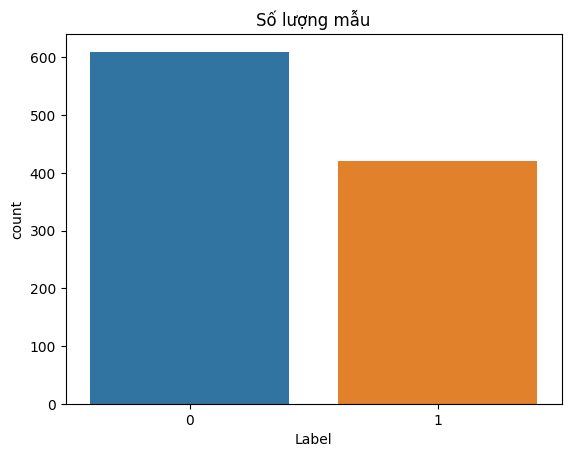

In [6]:
sns.countplot(data=df, x='Label').set(title='Số lượng mẫu')

### WordCloud trước khi tiền xử lý

In [7]:
def plot_wordcloud(sentences):
    plt.figure(figsize=(20, 20))
    wordcloud = WordCloud(max_words=200, background_color='white').generate(sentences)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


def plot_histogram(joined_sentences):
    # join các từ lại
    words_df = joined_sentences.split(sep=' ')

    # Tính số lượng từng từ có trong dataset
    words_df_dict = dict(Counter(words_df))
    words_df_dict = dict(sorted(words_df_dict.items(), key=lambda item: item[1], reverse=False))

    # plot 20 từ xuất hiện nhiều nhất
    histo = pd.DataFrame(words_df_dict.values(), index=words_df_dict.keys(), columns=['Count']).tail(20)
    histo.plot.barh()

- <i>Số lượng từ các văn bảng trong tập dữ liệu trước khi tiền xử lý</i>

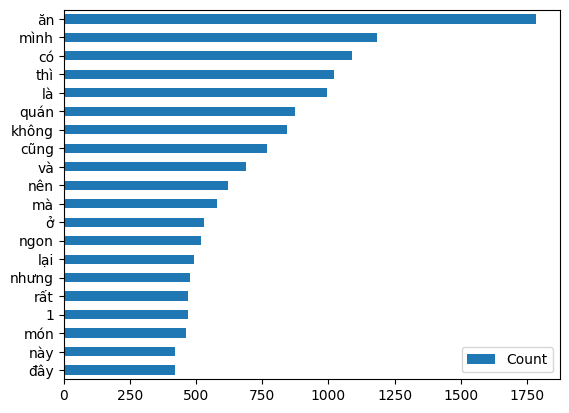

In [8]:
plot_histogram(joined_sentences)

- <i>WordCloud của tất cả các review</i>

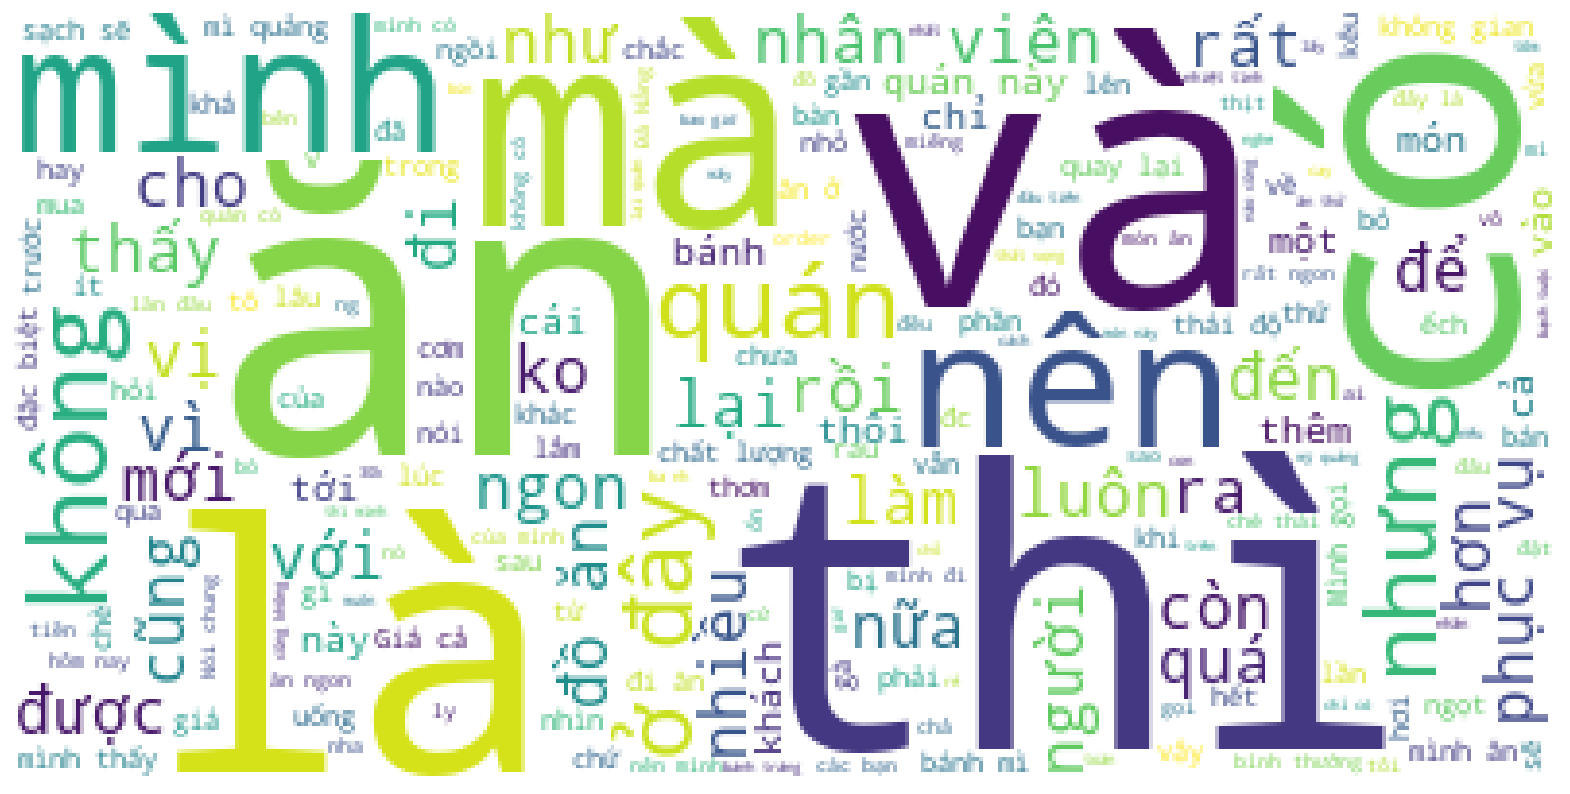

In [9]:
plot_wordcloud(joined_sentences)

In [10]:
negative = df[df['Label'] == 1]
positive = df[df["Label"] == 0]

negative_sentences = " ".join(negative['Review'].tolist())
positive_sentences = " ".join(positive['Review'].tolist())

- <i>WordCloud của các bình luận tiêu cực</i>

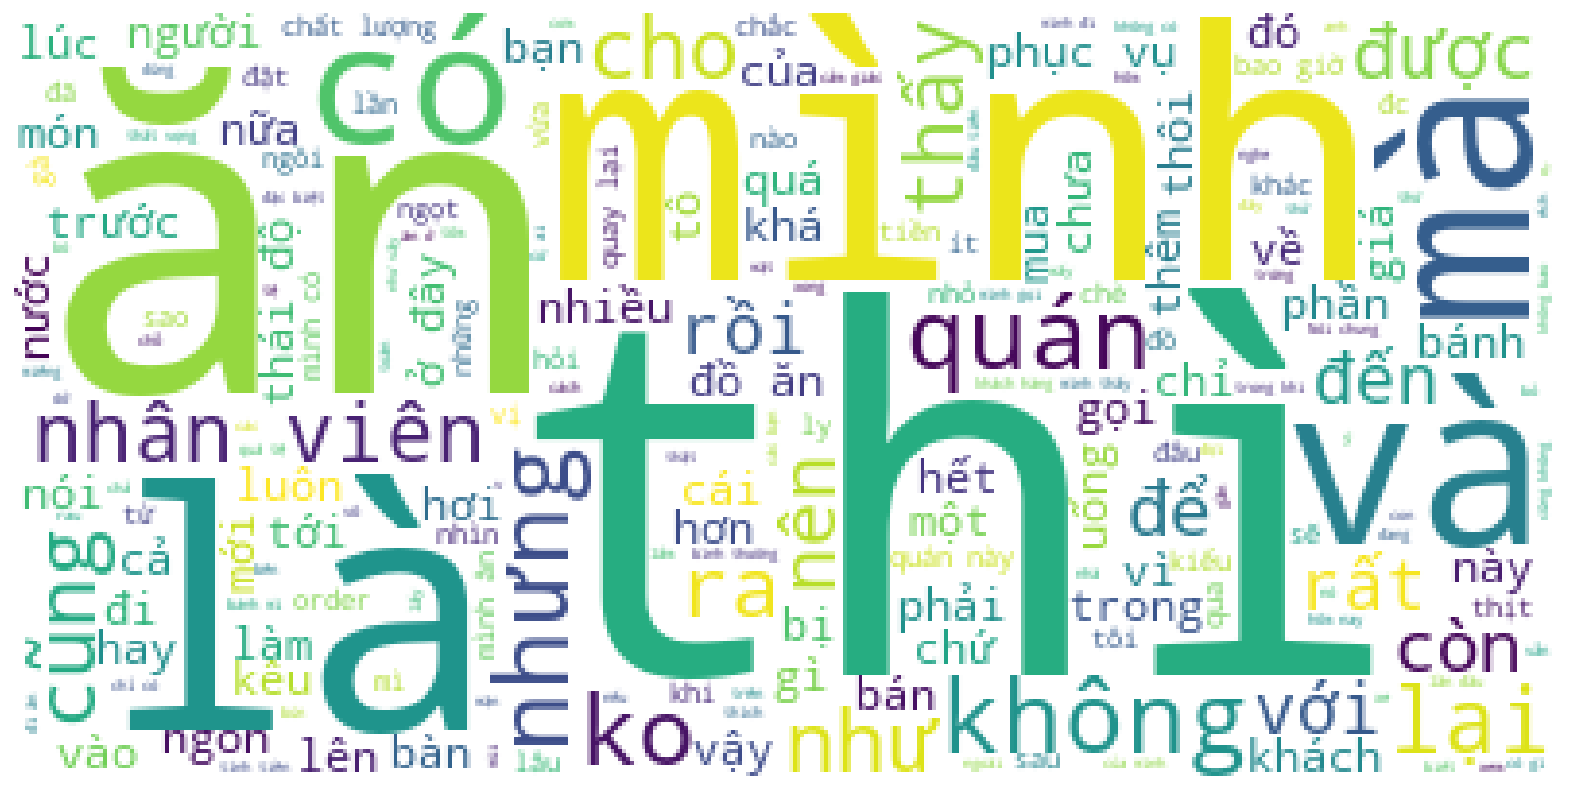

In [11]:
plot_wordcloud(negative_sentences)

- <i>WordCloud của các bình luận tích cực</i>

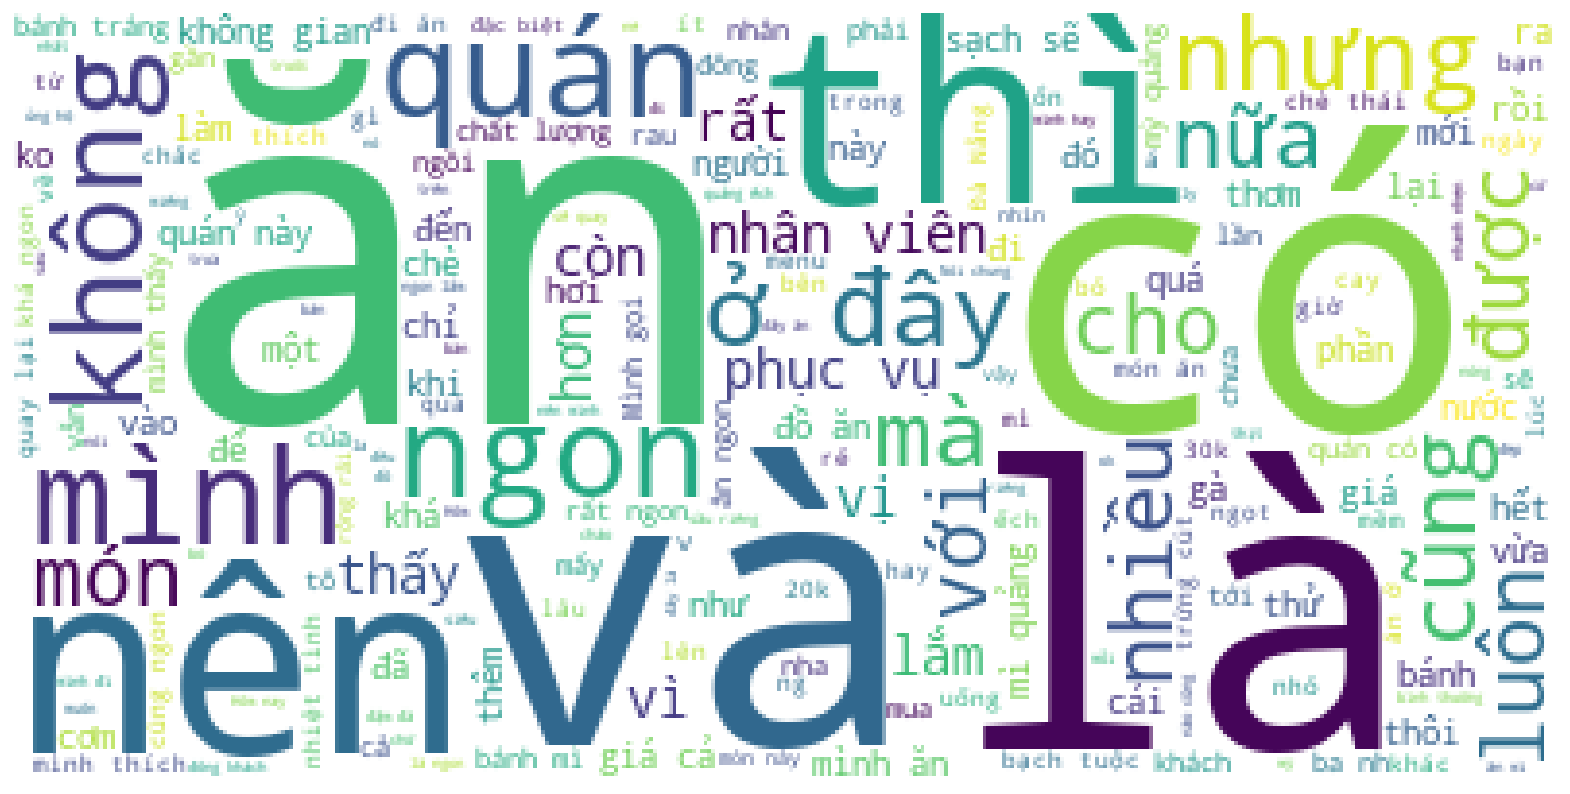

In [12]:
plot_wordcloud(positive_sentences)

### WordCloud sau khi tiền xử lý

Hàm tiền xử lý chuỗi

In [13]:
def tokenize_vietnamese_text(text):
    tokens = ViTokenizer.tokenize(text)
    return tokens


def get_stopwords(url):
    with open(url, 'r+', encoding='utf8') as file:
        stopwords = file.readlines()
        return set(stopwords)
    
    
stopwords = get_stopwords('vietnamese_stopwords_dash.txt')

# dùng regex để xoá các emoji
emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  # chinese char
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642"
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                            "]+", flags=re.UNICODE)
def review_cleaning(message):
    # chuyển hết chuỗi sang chữ thường
    message = message.lower()

    # xoá các emoji
    message = emoji_pattern.sub(r'', message)
    
    # xoá các kí tự đặc biệt
    removed_punc_str = [char for char in message if char not in string.punctuation]
    removed_punc_str = ''.join(removed_punc_str)

    # tách các từ ghép
    removed_punc_str = tokenize_vietnamese_text(removed_punc_str)

    # xoá các stopwords
    clean_removed_punc_str = [word for word in removed_punc_str.split() if word.lower() not in stopwords]
    return clean_removed_punc_str

In [14]:
def list_to_str(message):
    return " ".join(message)

In [15]:
clean_df = pd.DataFrame(df['Review'].apply(review_cleaning))

clean_df['Review'] = clean_df['Review'].apply(list_to_str)
clean_df['Point'] = df['Point']
# lưu clean data vào file
clean_df.to_csv('clean_data.csv', index=False)
clean_df['Label'] = df['Label']

clean_sentences = " ".join(clean_df['Review'].tolist())

<i>Dữ liệu cột review sau khi tiền xử lý</i>

In [16]:
print(clean_df['Review'])

0       quán không_gian không có địa_điểm ăn tại_chỗ t...
1       mình có ord ở đây 2combo bánh_mì tiêu đen coca...
2       đặt mỳ gà v mỳ bò về ăn mỳ quảng_ăn được tô 25...
3       hôm bữa đi ăn 2 phần bún đậu có gọi thêm sữa_c...
4       ăn tô mì cay mà thảm_cảnh thật mì tôm việt_nam...
                              ...                        
1025    nhân_viên nhiệt_tình thân_thiện thức uống ngon...
1026    lăng_mạ chửi khách_hàng tự_ý lấy hình của khác...
1027    dimsum không ngon phục_vụ ok giá_cả chưa thật_...
1028    mọi hôm hay ăn bông lan trứng muối gí cả ok rấ...
1029    đến quán lúc 8h tối order 2 ly mang về sau đó ...
Name: Review, Length: 1030, dtype: object


- <i>Số lượng từ các văn bảng trong tập dữ liệu sau khi tiền xử lý</i>

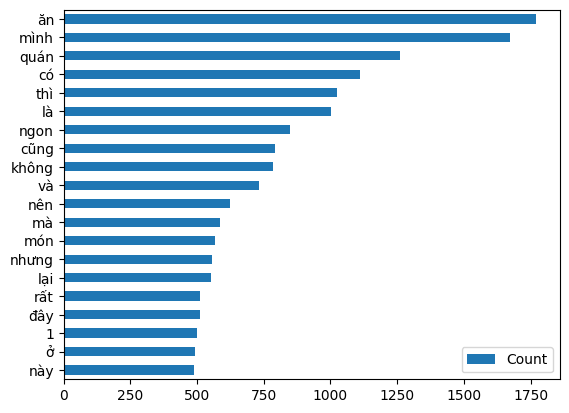

In [17]:
plot_histogram(clean_sentences)

- <i>WordCloud của tất cả các review</i>

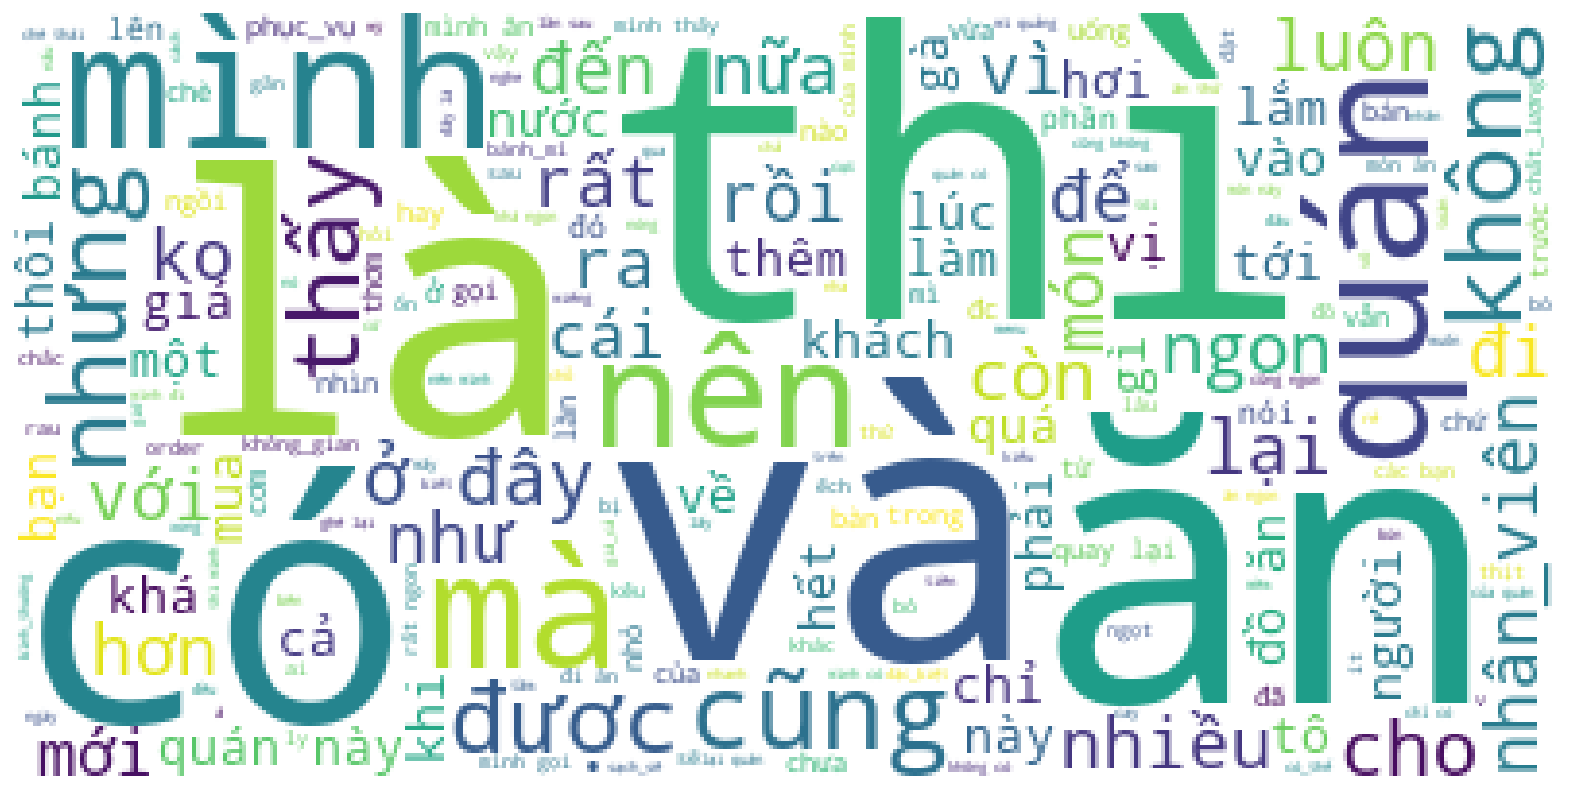

In [18]:
plot_wordcloud(clean_sentences)

In [19]:
clean_negative = clean_df[clean_df['Label'] == 1]
clean_positive = clean_df[clean_df['Label'] == 0]

clean_negative_sentences = " ".join(clean_negative['Review'].tolist())
clean_positive_sentences = " ".join(clean_positive['Review'].tolist())

- <i>WordCloud của các bình luận tiêu cực</i>

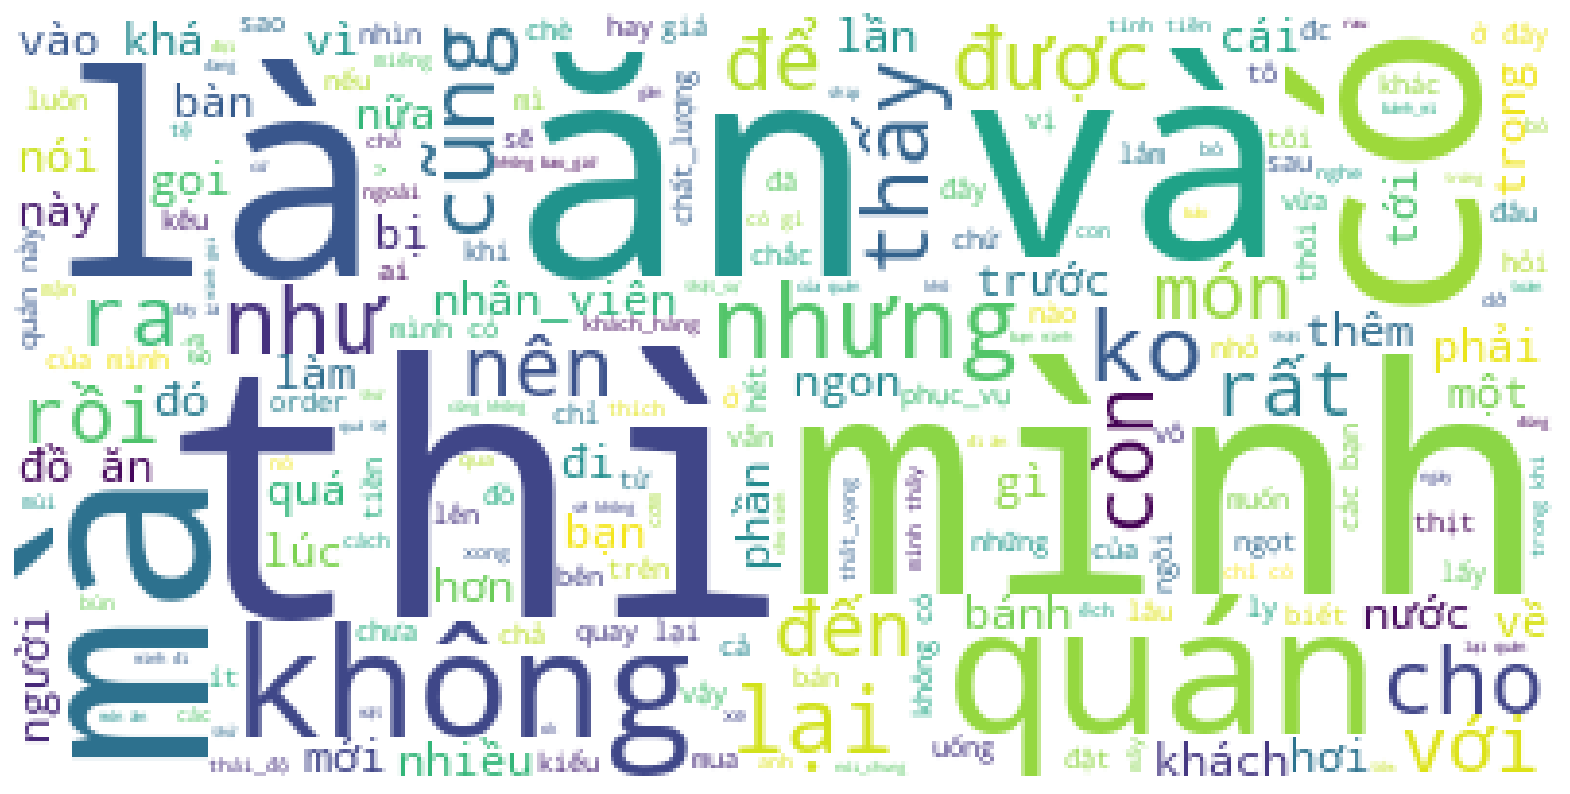

In [20]:
plot_wordcloud(clean_negative_sentences)

- <i>WordCloud của các bình luận tích cực</i>

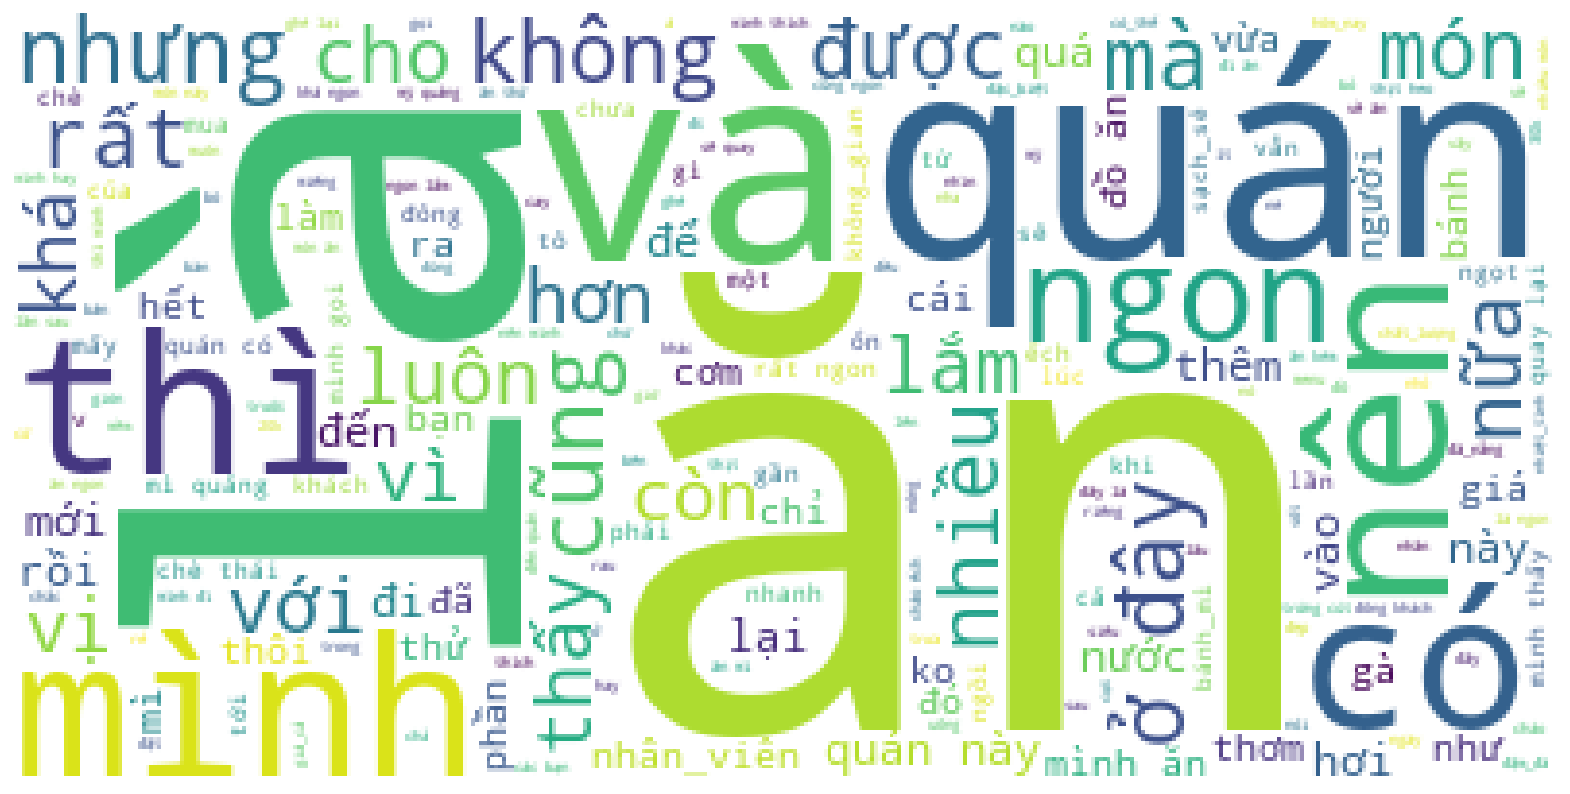

In [21]:
plot_wordcloud(clean_positive_sentences)

## Vector hoá văn bản và trực quan hoá dữ liệu

In [22]:
def plot_vectorizer(matrix, label):

    # dùng t-sne để giảm chiều dữ liệu xuống còn 3 chiều
    tsne = TSNE(n_components=3, random_state=0)
    matrix_3d = tsne.fit_transform(matrix.toarray())
    
    x = matrix_3d[:, 0]
    y = matrix_3d[:, 1]
    z = matrix_3d[:, 2]

    # Tạo đối tượng Figure
    fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(color=label, colorscale='Viridis', size=5, opacity=0.8))])

    # Cấu hình các trục và góc nhìn ban đầu
    fig.update_layout(scene=dict(
        xaxis=dict(nticks=4,),
        yaxis=dict(nticks=4,),
        zaxis=dict(nticks=4,),
        camera=dict(
            up=dict(x=0, y=0, z=1),
            eye=dict(x=1.25, y=1.25, z=1.25)
        )
    ))

    # Hiển thị hình ảnh 3D tương tác
    fig.show()

### CountVectorizer

<i>Áp dụng countvectorizer để vector hoá văn bản</i>
<br>
- Count_matrix có số chiều là 4956 (bằng với số từ vựng của tập dữ liệu vào)
- Count_matrix có số hàng là 1030 (bằng với số tập mẫu văn bản)

In [23]:
# Áp dụng vector
vectorizer = CountVectorizer(analyzer=review_cleaning)
count_matrix = vectorizer.fit_transform(df['Review'])
count_matrix

<1030x4956 sparse matrix of type '<class 'numpy.int64'>'
	with 53421 stored elements in Compressed Sparse Row format>

<i>Áp dụng t-SNE giảm chiều dữ liệu để trực quán hoá lên đồ thị 3 chiều</i>

In [24]:
plot_vectorizer(count_matrix, df['Label'])

### TfidfVectorizer

<i>Áp dụng tfidfvectorizer để vector hoá văn bản</i>
<br>
- count_matrix có số chiều là 5063 (bằng với số từ vựng của tập dữ liệu vào)
- count_matrix có số hàng là 1030 (bằng với số tập mẫu văn bản)

In [25]:
# Create a CountVectorizer object and apply it to the 'review' column
vectorizer = TfidfVectorizer(analyzer=review_cleaning)
tfidf_matrix = vectorizer.fit_transform(df['Review'])
tfidf_matrix

<1030x4956 sparse matrix of type '<class 'numpy.float64'>'
	with 53421 stored elements in Compressed Sparse Row format>

<i>Áp dụng t-SNE giảm chiều dữ liệu để trực quán hoá lên đồ thị 3 chiều</i>

In [26]:
plot_vectorizer(tfidf_matrix, df['Label'])

<b>Nhận xét: </b>
    <i>Sau khi áp dụng t-SNE để giảm chiều dữ liệu xuống còn 3 chiều và trực quan hoá dữ liệu. Ta thấy TF-IDF Vectorizer chỉ ra mức độ phân lớp trên đồ thị tốt hơn Count Vectorizer</i>

## Huấn luyện mô hình

In [27]:
def plot_confusion_matrix(x_test, y_test, model:GridSearchCV):
    # Dự đoán tập test
    y_pred = model.predict(x_test)

    # plot ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    print(classification_report(y_test, y_pred))


def train_model(vectorizer, classifier, x, y, cv=5):
    # Tạo pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    # cross_validate để dự đoán độ chính xác khi train
    y_pred = cross_val_predict(pipeline, x, y, cv=cv)
    accu = accuracy_score(y, y_pred)
    print('Accuracy score: {}'.format(accu))
    # cm = confusion_matrix(y, y_pred)
    # sns.heatmap(cm, annot=True, fmt='d')
    # print(classification_report(y, y_pred))
    return pipeline.fit(x, y)


def train_model_with_hyperparameters(vectorizer, classifier, x, y, cv=5):
    # Tạo pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    # Kiểm tra mô hình chọn để lựa chọn đúng bộ siêu tham số
    if isinstance(classifier, MultinomialNB):
        para_grid = {
            'classifier__alpha': [0.1, 0.5, 1.0],
            'classifier__fit_prior': [True, False]
        }
        columns = ['rank_test_score', 'mean_test_score', 'param_classifier__alpha','param_classifier__fit_prior']
    # thêm hyperparameters sau tuỳ theo mô hình lựa chọn
    else:
        para_grid = {
            'classifier__penalty': ['l1', 'l2'],
            'classifier__C': [1.0, 0.1, 0.01, 0.001]
        }
        columns = ['rank_test_score', 'mean_test_score', 'param_classifier__penalty','param_classifier__C']

    # Tìm kiếm bộ tham số tối ưu cho mô hình
    grid_search = GridSearchCV(pipeline, param_grid=para_grid, scoring='accuracy', cv=cv)

    search_result = grid_search.fit(x, y)
    result = pd.DataFrame(search_result.cv_results_, columns=columns).sort_values(by='rank_test_score')
    print("Best score: {} with hyperparameters {}".format(search_result.best_score_, search_result.best_params_))

    # Trả về kết quả, lần lượt và mô hình đã train và kết quả khi train với từng bộ tham số
    return search_result, result

### Huấn luyện trên small data

In [28]:
# Đọc dữ liệu từ small data
small_df = pd.read_csv('small_data.csv')
small_df['Label'] = small_df['Point'].apply(lambda point: 0 if point >= 6 else 1)
x = small_df['Review']
y = small_df['Label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

#### Mô hình Naive Bayes

##### CountVectorizer làm input

###### Không dùng hyperparameters

In [29]:
train_model(CountVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)

Accuracy score: 0.8807212205270458


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function review_cleaning at 0x000001E0971B6280>)),
                ('classifier', MultinomialNB())])

###### Có dùng hyperparameters

In [30]:
model, result = train_model_with_hyperparameters(CountVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)
result.head()

Best score: 0.8862739463601532 with hyperparameters {'classifier__alpha': 0.5, 'classifier__fit_prior': False}


,rank_test_score,mean_test_score,param_classifier__alpha,param_classifier__fit_prior
3,1,0.886274,0.5,False
5,2,0.884895,1.0,False
1,3,0.884885,0.1,False
2,4,0.883506,0.5,True
0,5,0.882117,0.1,True


<b>Nhận xét:</b><i> việc sử dụng bộ tham số tối ưu với input là CountVectorizer trong mô hình Naive Bayes không cải thiện đáng kể độ chính xác của thuật toán</i>

###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       183
           1       0.89      0.75      0.82       126

    accuracy                           0.86       309
   macro avg       0.87      0.84      0.85       309
weighted avg       0.86      0.86      0.86       309



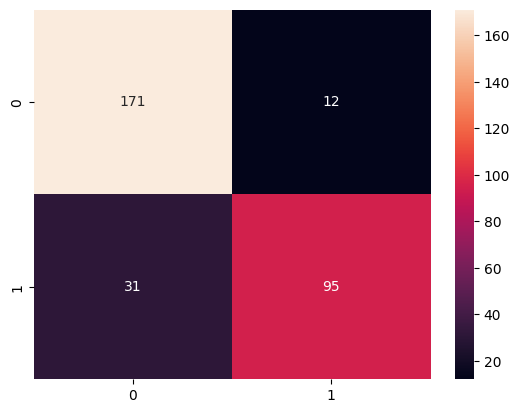

In [31]:
plot_confusion_matrix(x_test, y_test, model)

##### TfidfVectorizer làm input

###### Không dùng hyperparameters

In [32]:
train_model(TfidfVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)

Accuracy score: 0.7517337031900139


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function review_cleaning at 0x000001E0971B6280>)),
                ('classifier', MultinomialNB())])

###### Có dùng hyperparameters

In [33]:
model, result = train_model_with_hyperparameters(TfidfVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)
result.head()

Best score: 0.8862739463601533 with hyperparameters {'classifier__alpha': 0.1, 'classifier__fit_prior': False}


,rank_test_score,mean_test_score,param_classifier__alpha,param_classifier__fit_prior
1,1,0.886274,0.1,False
0,2,0.875172,0.1,True
3,3,0.865460,0.5,False
5,4,0.822481,1.0,False
2,5,0.819713,0.5,True


<b>Nhận xét: </b><i>việc sử dụng bộ tham số tối ưu với input là TdidfVectorizer trong mô hình Naive Bayes cải thiện rất lớn tới độ chính xác của thuật toán. Độ chính xác tăng <b>13.46%</b>, từ <b>75.17%</b> lên <b>88.63%</b></i>

###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       183
           1       0.88      0.78      0.83       126

    accuracy                           0.87       309
   macro avg       0.87      0.85      0.86       309
weighted avg       0.87      0.87      0.87       309



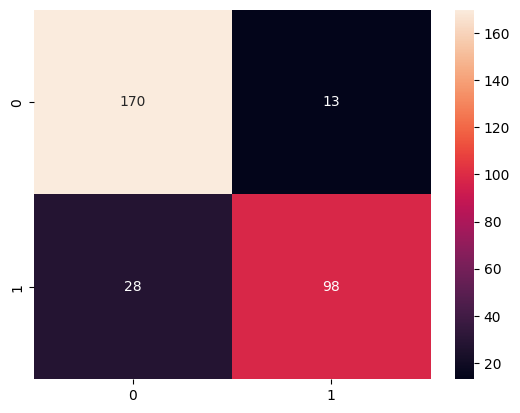

In [34]:
plot_confusion_matrix(x_test, y_test, model)

#### Mô hình Support Vector Machine

##### CountVectorizer làm input

###### Không dùng hyperparameters

In [35]:
train_model(CountVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)

Accuracy score: 0.8155339805825242


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function review_cleaning at 0x000001E0971B6280>)),
                ('classifier', LinearSVC(dual=False))])

###### Có dùng hyperparameters

In [36]:
model, result = train_model_with_hyperparameters(CountVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)
result.head()

Best score: 0.8668582375478928 with hyperparameters {'classifier__C': 0.01, 'classifier__penalty': 'l2'}


,rank_test_score,mean_test_score,param_classifier__penalty,param_classifier__C
5,1,0.866858,l2,0.01
7,2,0.846092,l2,0.001
3,3,0.843305,l2,0.1
2,4,0.829377,l1,0.1
1,5,0.815594,l2,1.0


<b>Nhận xét:</b><i> việc sử dụng bộ tham số tối ưu với input là CountVectorizer trong mô hình Support Vector Machine cải thiện tương đối độ chính xác của thuật toán, từ <b>81.55%</b> lên <b>86.69%</b></i>

###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       183
           1       0.88      0.79      0.84       126

    accuracy                           0.87       309
   macro avg       0.88      0.86      0.87       309
weighted avg       0.87      0.87      0.87       309



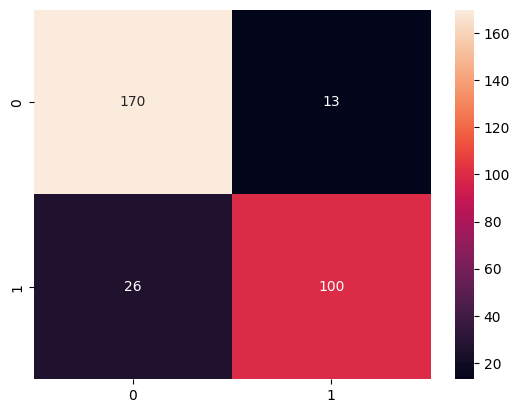

In [37]:
plot_confusion_matrix(x_test, y_test, model)

##### TfidfVectorizer làm input

###### Không dùng hyperparameters

In [38]:
train_model(TfidfVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)

Accuracy score: 0.8765603328710125


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function review_cleaning at 0x000001E0971B6280>)),
                ('classifier', LinearSVC(dual=False))])

###### Có dùng hyperparameters

In [39]:
model, result = train_model_with_hyperparameters(TfidfVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)
result.head()

Best score: 0.8807471264367817 with hyperparameters {'classifier__C': 0.1, 'classifier__penalty': 'l2'}


,rank_test_score,mean_test_score,param_classifier__penalty,param_classifier__C
3,1,0.880747,l2,0.1
1,2,0.876580,l2,1.0
0,3,0.846044,l1,1.0
2,4,0.671312,l1,0.1
5,5,0.597778,l2,0.01


<b>Nhận xét:</b><i> việc sử dụng bộ tham số tối ưu với input là TfidfVectorizer trong mô hình Support Vector Machine không cải thiện độ chính xác của thuật toán</i>

###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       183
           1       0.92      0.74      0.82       126

    accuracy                           0.87       309
   macro avg       0.88      0.85      0.86       309
weighted avg       0.87      0.87      0.86       309



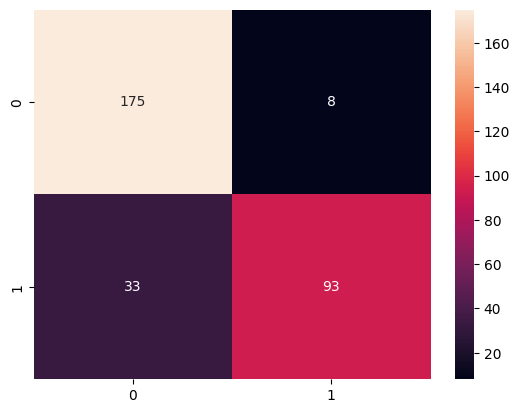

In [40]:
plot_confusion_matrix(x_test, y_test, model)

### Huấn luyện trên big data

In [41]:
# Đọc dữ liệu từ small data
big_df = pd.read_csv('big_data.csv')
big_df['Label'] = big_df['Point'].apply(lambda point: 0 if point >= 6 else 1)
x = big_df['Review']
y = big_df['Label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

[Text(0.5, 1.0, 'Số lượng mẫu')]

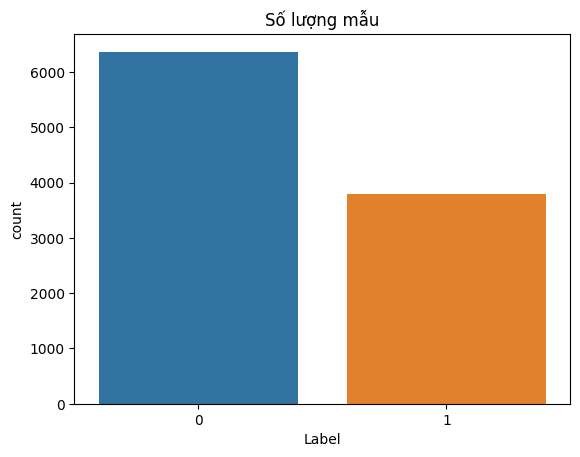

In [42]:
sns.countplot(data=big_df, x='Label').set(title='Số lượng mẫu')

#### Mô hình Naive Bayes

##### CountVectorizer làm input

###### Không dùng hyperparameters

In [43]:
train_model(CountVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)

Accuracy score: 0.9105211406096362


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function review_cleaning at 0x000001E0971B6280>)),
                ('classifier', MultinomialNB())])

###### Có dùng hyperparameters

In [44]:
model, result = train_model_with_hyperparameters(CountVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)
result.head()

Best score: 0.9237255916050124 with hyperparameters {'classifier__alpha': 0.1, 'classifier__fit_prior': False}


,rank_test_score,mean_test_score,param_classifier__alpha,param_classifier__fit_prior
1,1,0.923726,0.1,False
0,2,0.922181,0.1,True
3,3,0.917264,0.5,False
2,4,0.915860,0.5,True
5,5,0.913051,1.0,False


<b>Nhận xét:</b><i> việc sử dụng bộ tham số tối ưu với input là CountVectorizer trong mô hình Naive Bayes không cải thiện đáng kể độ chính xác của thuật toán</i>

###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1911
           1       0.95      0.88      0.91      1140

    accuracy                           0.94      3051
   macro avg       0.94      0.92      0.93      3051
weighted avg       0.94      0.94      0.94      3051



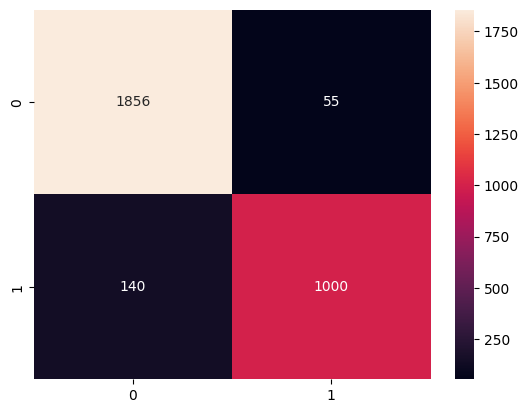

In [45]:
plot_confusion_matrix(x_test, y_test, model)

##### TfidfVectorizer làm input

###### Không dùng hyperparameters

In [46]:
train_model(TfidfVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)

Accuracy score: 0.8613569321533924


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function review_cleaning at 0x000001E0971B6280>)),
                ('classifier', MultinomialNB())])

###### Có dùng hyperparameters

In [47]:
model, result = train_model_with_hyperparameters(TfidfVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)
result.head()

Best score: 0.9315927341350367 with hyperparameters {'classifier__alpha': 0.1, 'classifier__fit_prior': False}


,rank_test_score,mean_test_score,param_classifier__alpha,param_classifier__fit_prior
1,1,0.931593,0.1,False
0,2,0.924990,0.1,True
3,3,0.918669,0.5,False
5,4,0.897037,1.0,False
2,5,0.896335,0.5,True


<b>Nhận xét:</b><i> việc sử dụng bộ tham số tối ưu với input là TfidfVectorizer trong mô hình Naive Bayes cải thiện tương đối tới độ chính xác của thuật toán. Tăng từ <b>86.13%</b> lên <b>93.16%</b></i>

###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1911
           1       0.94      0.89      0.92      1140

    accuracy                           0.94      3051
   macro avg       0.94      0.93      0.93      3051
weighted avg       0.94      0.94      0.94      3051



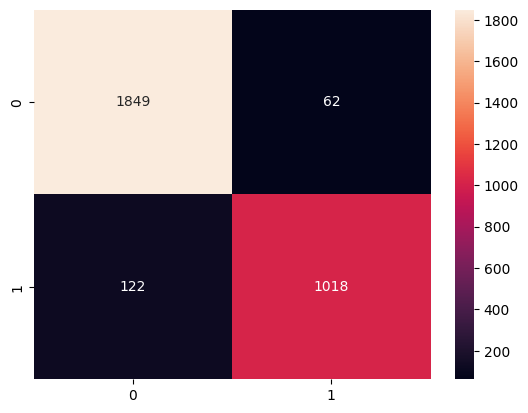

In [48]:
plot_confusion_matrix(x_test, y_test, model)

#### Mô hình Support Vector Machine

##### CountVectorizer làm input

###### Không dùng hyperparameters

In [49]:
train_model(CountVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)

Accuracy score: 0.9513976682118275


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function review_cleaning at 0x000001E0971B6280>)),
                ('classifier', LinearSVC(dual=False))])

###### Có dùng hyperparameters

In [50]:
model, result = train_model_with_hyperparameters(CountVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)
result.head()

Best score: 0.9540676052334442 with hyperparameters {'classifier__C': 0.1, 'classifier__penalty': 'l2'}


,rank_test_score,mean_test_score,param_classifier__penalty,param_classifier__C
3,1,0.954068,l2,0.1
1,2,0.951399,l2,1.0
0,3,0.950276,l1,1.0
5,4,0.937352,l2,0.01
2,5,0.930611,l1,0.1


<b>Nhận xét:</b><i> việc sử dụng bộ tham số tối ưu với input là CountVectorizer trong mô hình Support Vector Machine không cải thiện được độ chính xác</i>

###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1911
           1       0.96      0.95      0.95      1140

    accuracy                           0.97      3051
   macro avg       0.96      0.96      0.96      3051
weighted avg       0.97      0.97      0.97      3051



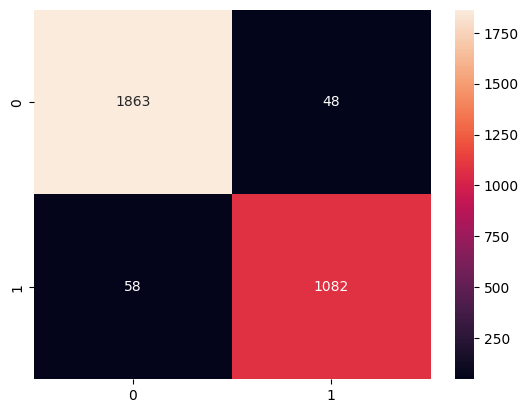

In [51]:
plot_confusion_matrix(x_test, y_test, model)

##### TfidfVectorizer làm input

###### Không dùng hyperparameters

In [52]:
train_model(TfidfVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)

Accuracy score: 0.9567354965585054


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function review_cleaning at 0x000001E0971B6280>)),
                ('classifier', LinearSVC(dual=False))])

###### Có dùng hyperparameters

In [53]:
model, result = train_model_with_hyperparameters(TfidfVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)
result.head()

Best score: 0.9567368354560312 with hyperparameters {'classifier__C': 1.0, 'classifier__penalty': 'l2'}


,rank_test_score,mean_test_score,param_classifier__penalty,param_classifier__C
1,1,0.956737,l2,1.0
0,2,0.944376,l1,1.0
3,3,0.931031,l2,0.1
2,4,0.878355,l1,0.1
5,5,0.866275,l2,0.01


<b>Nhận xét:</b><i> việc sử dụng siêu tham bộ tham số tối ưu với input là TfidfVectorizer trong mô hình Support Vector Machine không cải thiện được độ chính xác</i>

###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1911
           1       0.97      0.95      0.96      1140

    accuracy                           0.97      3051
   macro avg       0.97      0.97      0.97      3051
weighted avg       0.97      0.97      0.97      3051



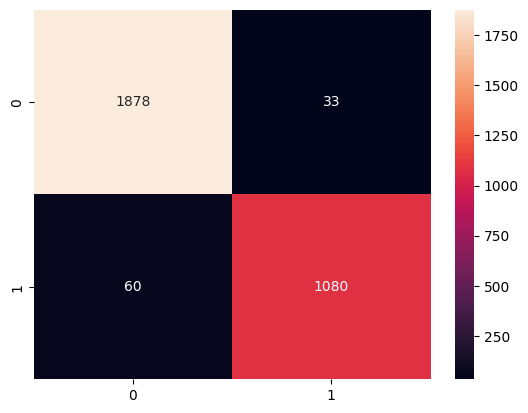

In [54]:
plot_confusion_matrix(x_test, y_test, model)

## Nhận xét và kết luận

### Trong quá trình huấn luyện mô hình

- Việc sử dụng bộ siêu tham số không ảnh hưởng tới độ chính xác khi sử dụng <b>CountVectorizer</b> làm input. Tuy nhiên nó lại cải thiện đáng kể khi sử dụng <b>TfidfVectorizer</b> làm input. Đặc biệt với dataset nhỏ thì có thể cải thiện độ chính xác lên tới <b><i>13.46%</i></b>.

- Khi huấn luyện trên dataset nhỏ thì mô hình <b><i>Naive Bayes</i></b> cho độ chính xác cao khi áp dụng với <b><i>CountVectorizer</i></b>. Trong khi đó thì mô hình <b><i>Support Vector Machine</i></b> đáp ứng tốt với <b><i>TfidfVectorizer</i></b>.

- Khi huấn luyện trên dataset lớn thì việc sử dụng bộ siêu tham số gần như không cải thiện độ chính xác của thuật toán.

- Huấn luyện trên dataset lớn luôn cho kết quả tốt hơn dataset nhỏ.

### Trong quá trình kiểm thử

- Khi kiểm thử với 2 mô hình có sử dụng bộ siêu tham số thì kết quả của tập test với 2 input khác nhau đều cho kết quả tương đương nhau. Giá trị của metric <b><i>accuracy</i></b>(độ chính xác) nằm trong khoảng <b>86-87%</b> đối với dataset nhỏ, <b>94-97%</b> đối với dataset lớn.

- Với mô hình được huấn luyện trên dataset lớn, mô hình <b><i>Support Vector Machine</i></b> cho kết quả nhỉn hơn(<b>metric accuracy</b>) so với <b><i>Naive Bayes</i></b> khi kiểm thử. (<b></i>97% so với 94%</i></b>)

- Khi kiểm thử với mô hình được huấn luyện trên dataset nhỏ, giá trị <b><i>metric precision</i></b> đối với đánh giá tích tiêu cực tốt hơn so với tích cực. Tuy nhiên, với <b><i>metric recall và f1-score</i></b> thì giá trị của đánh giá tích cực tốt hơn rất nhiều so với tiêu cực

- Khi kiểm thử với mô hình được huấn luyện trên dataset lớn thì tất cả các metric có giá trị tương đương nhau